# Networkx

In [1]:
# stuff to import
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# create a directed graph and add nodes
DG = nx.DiGraph()
DG.add_node("rain")
DG.add_node("sprinkler")
DG.add_node("grass wet")
DG.add_node("sidewalk wet")
DG.add_node("person slipped")

In [3]:
DG.number_of_nodes()

5

In [4]:
list(DG.nodes)

['rain', 'sprinkler', 'grass wet', 'sidewalk wet', 'person slipped']

In [5]:
# add edges
edge_list = [("rain", "grass wet", 0.9), ("rain", "sidewalk wet", 0.75), ("sprinkler", "grass wet", 0.8), ("sidewalk wet", "person slipped", 0.4)]
DG.add_weighted_edges_from(edge_list)
list(DG.edges)

[('rain', 'grass wet'),
 ('rain', 'sidewalk wet'),
 ('sprinkler', 'grass wet'),
 ('sidewalk wet', 'person slipped')]

In [6]:
# neighbors list *direct* children (out-edges)
print(list(DG.neighbors("rain")))
print(list(DG.neighbors("grass wet")))

['grass wet', 'sidewalk wet']
[]


In [7]:
# see all out-edges
print(list(DG.out_edges("rain")))

[('rain', 'grass wet'), ('rain', 'sidewalk wet')]


In [8]:
# see all descendants of a node (even indirect)
nx.descendants(DG, "rain")

{'grass wet', 'person slipped', 'sidewalk wet'}

In [9]:
# see all edges in the graph
nx.edges(DG)

OutEdgeView([('rain', 'grass wet'), ('rain', 'sidewalk wet'), ('sprinkler', 'grass wet'), ('sidewalk wet', 'person slipped')])

In [10]:
# see all weights for every edge in the graph
nx.get_edge_attributes(DG, 'weight')

{('rain', 'grass wet'): 0.9,
 ('rain', 'sidewalk wet'): 0.75,
 ('sprinkler', 'grass wet'): 0.8,
 ('sidewalk wet', 'person slipped'): 0.4}

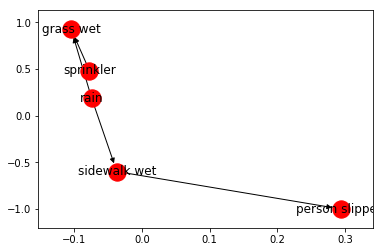

In [11]:
# draw the graph
nx.draw_networkx(DG)

## Similarity using jaccard index

In [12]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [34]:
# all children of rain
print(get_all_children(DG, "rain", {}))

{'grass wet': 0.9, 'sidewalk wet': 0.75, 'person slipped': 0.30000000000000004}


In [35]:
print(get_all_children(DG, "sprinkler", {}))

{'grass wet': 0.8}


In [36]:
# helper func to calculate the intersection
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter     

In [37]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [38]:
# helper func to calculate the union using method 1
def calculate_union_2(graph, children_a, children_b):
    union = 0
    for i in children_a:
        if i in children_b:
            union += abs(children_a[i] - children_b[i])
        else:
            union += children_a[i]
    for i in children_b:
        if not i in children_a:
            union += children_b[i]
    return union

In [39]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(DG, node_a, {})
    children_b = get_all_children(DG, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union_1 = calculate_union_1(graph, children_a, children_b)
    union_2 = calculate_union_2(graph, children_a, children_b)
    print(intersection)
    print(union_1)
    print(union_2)
    results = {"method 1": intersection/union_1, "method 2": intersection/union_2}
    return results

In [40]:
calculate_similarity(DG, "rain", "sprinkler")

0.8
1.95
1.15


{'method 1': 0.4102564102564103, 'method 2': 0.6956521739130436}

## edit distance

In [13]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

['sprinkler', 'grass wet']
[('sprinkler', 'grass wet')]


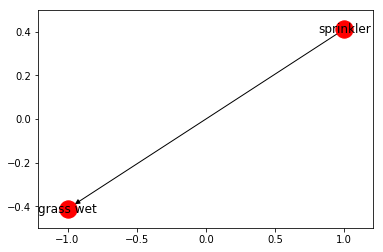

In [14]:
sprinkler_childgraph = nx.DiGraph()
sprinkler_childgraph.add_node("sprinkler")
sprinkler_childgraph = find_node_children_subgraph(DG, "sprinkler", sprinkler_childgraph)
print(list(sprinkler_childgraph.nodes))
print(list(sprinkler_childgraph.edges))
nx.draw_networkx(sprinkler_childgraph)

['rain', 'grass wet', 'sidewalk wet', 'person slipped']
[('rain', 'grass wet'), ('rain', 'sidewalk wet'), ('sidewalk wet', 'person slipped')]


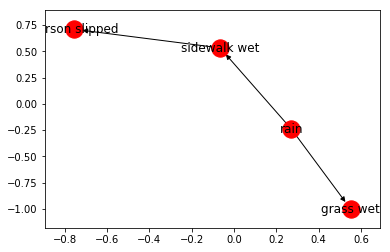

In [15]:
rain_childgraph = nx.DiGraph()
rain_childgraph.add_node("rain")
rain_childgraph = find_node_children_subgraph(DG, "rain", rain_childgraph)
print(list(rain_childgraph.nodes))
print(list(rain_childgraph.edges))
nx.draw_networkx(rain_childgraph)

In [99]:
# change graph_a to fit graph_b
def new_edit_distance(graph, graph_a, graph_b):
    b_nodes = nx.nodes(graph_b)
    b_edges = nx.edges(graph_b)
    a_nodes = nx.nodes(graph_a)
    a_edges = nx.edges(graph_a)
    weights = nx.get_edge_attributes(graph, 'weight')
    edit_distance = 0
    for i in b_edges:
        print("i" + str(i))
        for x in a_edges:
            print("x " + str(x))
            print((x[0], i[1]))
            if (x[0], i[1]) in a_edges and (x[1] == i[1]):
                edit_distance += abs(weights[(x[0], i[1])] - weights[i])
                print(edit_distance)
    return edit_distance

In [100]:
new_edit_distance(DG, rain_childgraph, sprinkler_childgraph)

i('sprinkler', 'grass wet')
x ('rain', 'grass wet')
('rain', 'grass wet')
0.09999999999999998
x ('rain', 'sidewalk wet')
('rain', 'grass wet')
x ('sidewalk wet', 'person slipped')
('sidewalk wet', 'grass wet')


0.09999999999999998

### edit distance with other similarity

In [54]:
G1 = nx.cycle_graph(6)
G2 = nx.wheel_graph(7)
nx.graph_edit_distance(G1, G2)

7.0

In [17]:
nx.graph_edit_distance(rain_childgraph, sprinkler_childgraph)

4.0

## other similarity

In [18]:
nx.algorithms.similarity.simrank_similarity(DG, source="rain", target="sprinkler")

AttributeError: module 'networkx.algorithms.similarity' has no attribute 'simrank_similarity'

In [19]:
sim = nx.simrank_similarity(G)

AttributeError: module 'networkx' has no attribute 'simrank_similarity'

In [20]:
weights = nx.get_edge_attributes(DG, 'weight')
weights

{('rain', 'grass wet'): 0.9,
 ('rain', 'sidewalk wet'): 0.75,
 ('sprinkler', 'grass wet'): 0.8,
 ('sidewalk wet', 'person slipped'): 0.4}

In [21]:
import networkx as nx
from numpy import array
G = nx.cycle_graph(4)
sim = nx.simrank_similarity_numpy(G)

AttributeError: module 'networkx' has no attribute 'simrank_similarity_numpy'